In [1]:
# !pip uninstall umap -y
# !pip install umap-learn

In [2]:
import os

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.metrics as skm


from sklearn.manifold import TSNE

import umap.umap_ as umap

In [3]:
WORD_DATA_PATH = "./herbier/data_public/words/"
METADATA_PATH = "./herbier/data_public/ascii/words.txt"

IMAGE_HEIGHT = IMAGE_WIDTH = 128

CLASSES = ['a01-000u', 'a01-003u']
N_CLASSES = len(CLASSES)

DEBUG = True

## TODO
- voir pour ignorer le fichier METADATA

Loaded 132 words.
  Writer ID: a01-000u; image shape: (51, 27, 1)
  Writer ID: a01-000u; image shape: (48, 213, 1)
  Writer ID: a01-000u; image shape: (50, 70, 1)
  Writer ID: a01-000u; image shape: (78, 166, 1)
  Writer ID: a01-000u; image shape: (61, 126, 1)
number of writers:  2


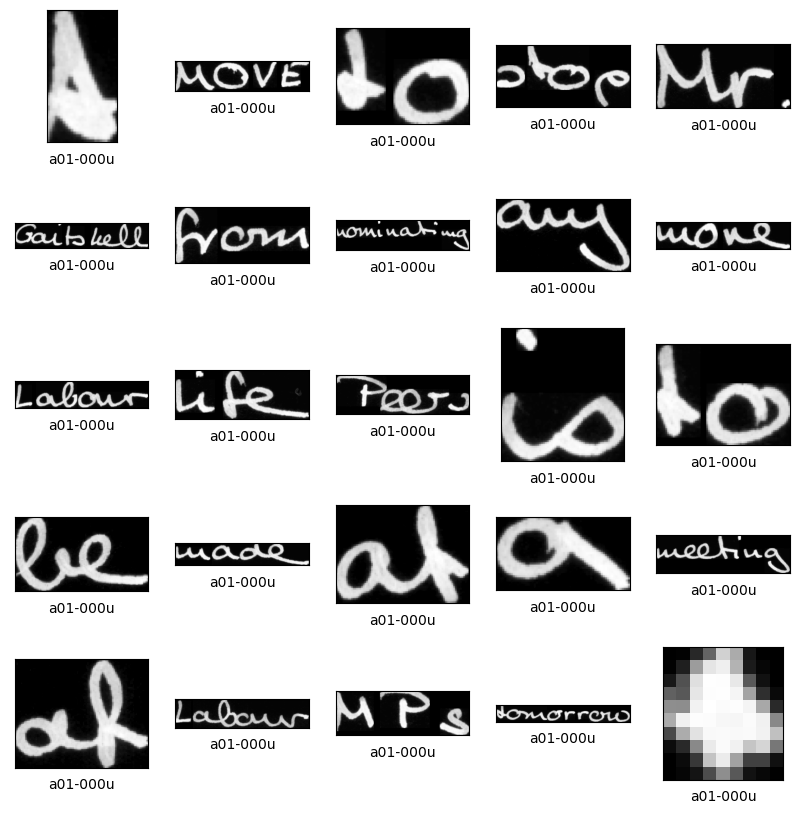

In [4]:
def load_words_data(data_path, metadata_path, selected_writers = []):
    if selected_writers == []:
        raise ValueError("selected_writers must be a non-empty list of writer IDs")

    data = []

    with open(metadata_path, 'r') as file:
        for line in file:
            if not line.startswith("#"):
                components = line.strip().split(' ')
                word_id = components[0]
                
                parts = word_id.split('-')
                writer_id = '-'.join(parts[:2])

                if writer_id in selected_writers:
                    image_subfolder = parts[0]
                    image_filename = f"{word_id}.png"
                    image_path = os.path.join(data_path, image_subfolder, writer_id, image_filename)
                    
                    if os.path.exists(image_path):
                        try:
                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img)
                            data.append({
                                'image_path': image_path,
                                'writer_id': writer_id,
                                'image_array': img
                            })
                        except tf.errors.InvalidArgumentError:
                            print(f"Image not found for word ID: {word_id} at {image_path}")
                    else:
                        print(f"Image not found for word ID: {word_id} at {image_path}")

    return data
 
words_data = load_words_data(WORD_DATA_PATH, METADATA_PATH, selected_writers=CLASSES)

if DEBUG:
  print(f"Loaded {len(words_data)} words.")
  for entry in words_data[:5]:
      print(f"  Writer ID: {entry['writer_id']}; image shape: {entry['image_array'].shape}")

if DEBUG: 
    print("number of writers: ", len(set([entry['writer_id'] for entry in words_data])))

if DEBUG:
  plt.figure(figsize=(10, 10))
  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(words_data[i]['image_array'], cmap=plt.cm.binary)
      plt.xlabel(words_data[i]['writer_id'])
  plt.show()


In [5]:
def preprocess_data(data):
    labels = []
    images = []

    for entry in data:
        # Resize the image
        img = tf.image.resize(entry['image_array'], [IMAGE_HEIGHT, IMAGE_WIDTH])

        img = img.numpy().astype('float32') / 255.0  # Normalize and convert to float32
        images.append(img)

        labels.append(entry['writer_id'])

    return np.array(images), np.array(labels)


images, labels = preprocess_data(words_data)

X_train, X_test, y_train, y_test = skms.train_test_split(images, labels, test_size=0.2, random_state=42)

if DEBUG:
    print(f"X_train: {X_train.shape}; y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}; y_test: {y_test.shape}")

X_train: (105, 128, 128, 1); y_train: (105,)
X_test: (27, 128, 128, 1); y_test: (27,)


In [6]:
# encode labels
label_encoder = skp.LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)
one_hot_encoded_labels = keras.utils.to_categorical(integer_encoded_labels)

X_train, X_test, y_train, y_test = skms.train_test_split(images, one_hot_encoded_labels, test_size=0.2, random_state=42)

integer_class_labels = np.argmax(y_train, axis=1)

if DEBUG:
    print(f"X_train: {X_train.shape}; y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}; y_test: {y_test.shape}")

X_train: (105, 128, 128, 1); y_train: (105, 2)
X_test: (27, 128, 128, 1); y_test: (27, 2)


In [7]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(N_CLASSES, activation='softmax')
])

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
BATCH_SIZE = 32
EPOCHS = 200

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/200


2023-12-26 22:26:06.419187: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 2s 418ms/step - loss: 31.8215 - accuracy: 0.4857 - val_loss: 1.3522 - val_accuracy: 0.3704
Epoch 2/200
4/4 [==============================] - 1s 344ms/step - loss: 10.3645 - accuracy: 0.5905 - val_loss: 7.1340 - val_accuracy: 0.5185
Epoch 3/200
4/4 [==============================] - 1s 338ms/step - loss: 11.7644 - accuracy: 0.6476 - val_loss: 5.1843 - val_accuracy: 0.5185
Epoch 4/200
4/4 [==============================] - 1s 341ms/step - loss: 8.8913 - accuracy: 0.7238 - val_loss: 16.2563 - val_accuracy: 0.5185
Epoch 5/200
4/4 [==============================] - 2s 399ms/step - loss: 9.2466 - accuracy: 0.6571 - val_loss: 21.8760 - val_accuracy: 0.5185
Epoch 6/200
4/4 [==============================] - 2s 420ms/step - loss: 8.3978 - accuracy: 0.7333 - val_loss: 17.7551 - val_accuracy: 0.5185
Epoch 7/200
4/4 [==============================] - 1s 347ms/step - loss: 3.0401 - accuracy: 0.8762 - val_loss: 15.2733 - val_accuracy: 0.5185
Epoch 8/200
4/4 [=

4/4 [==============================] - 0s 81ms/step


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


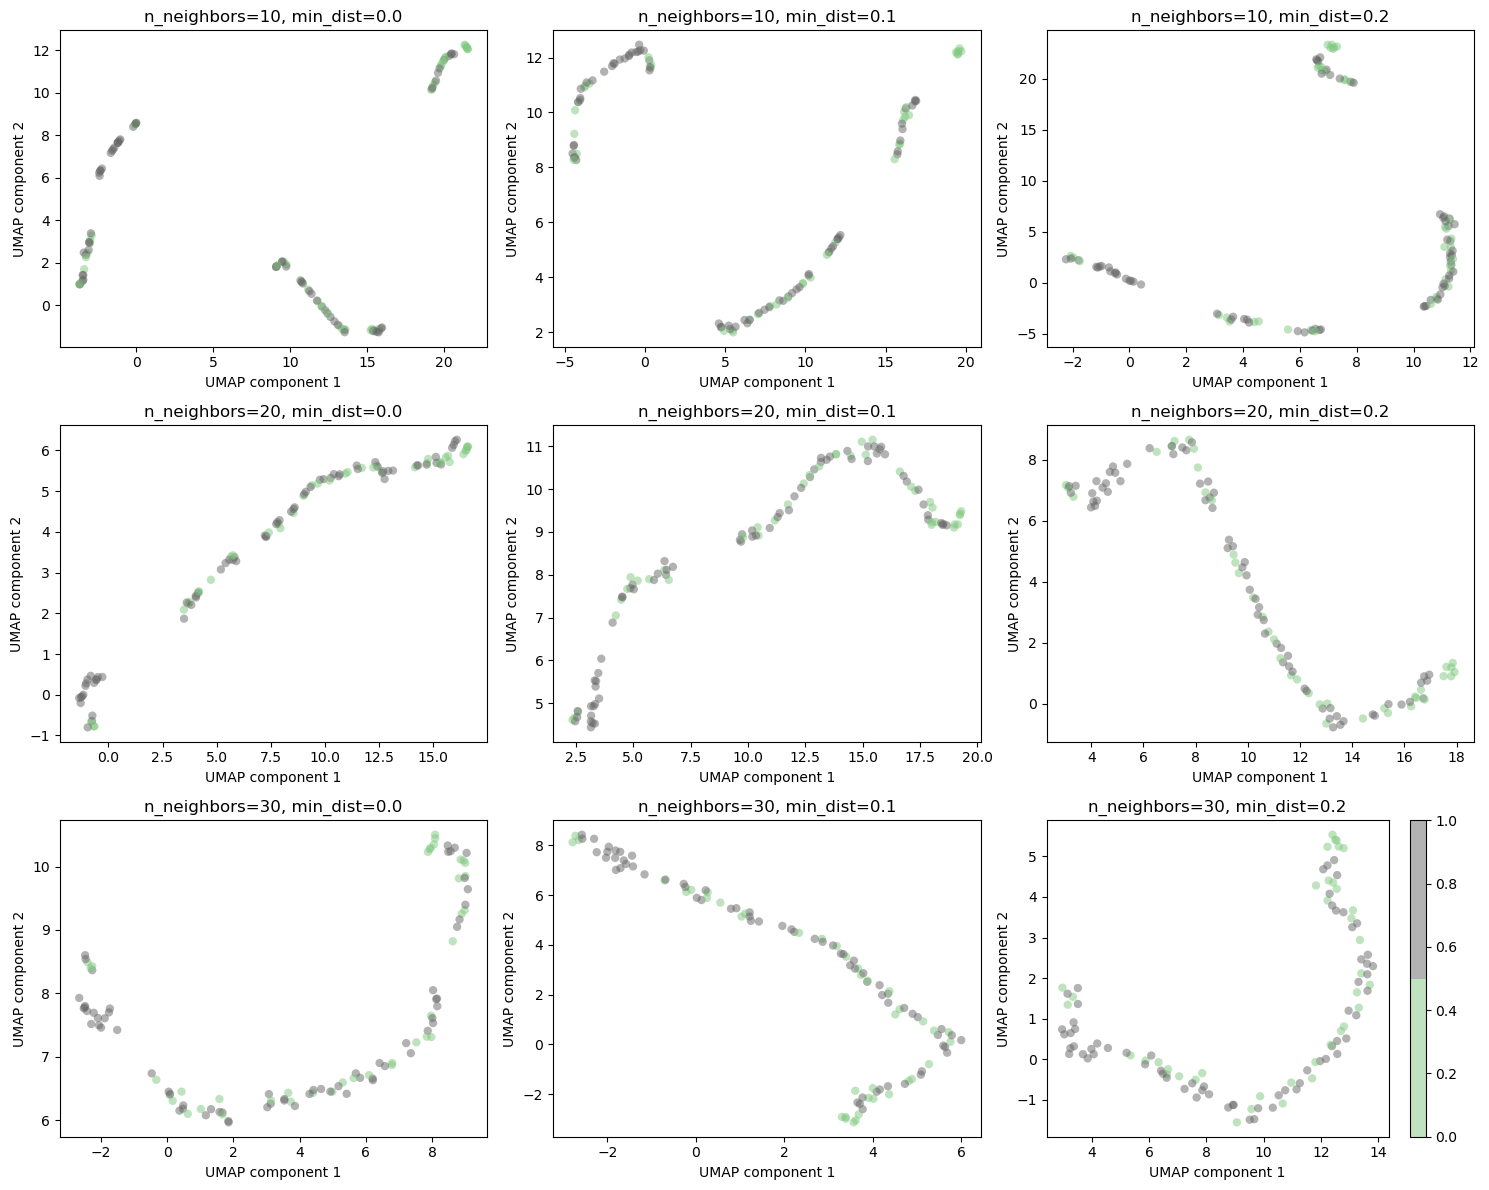

In [10]:
features = model.predict(X_train)


def evaluate_model(n_neighbors, min_dist, ax):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric='euclidean')
    embedding = reducer.fit_transform(np.nan_to_num(features))

    sc = ax.scatter(embedding[:, 0], embedding[:, 1],
                    c=integer_class_labels, edgecolor='none', alpha=0.5,
                    cmap=plt.cm.get_cmap('Accent', N_CLASSES))
    ax.set_xlabel('UMAP component 1')
    ax.set_ylabel('UMAP component 2')
    ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

    if n_neighbors == n_neighbors_list[-1] and min_dist == min_dist_list[-1]:
        plt.colorbar(sc, ax=ax)

n_neighbors_list = [10, 20, 30]
min_dist_list = [0.0, 0.1, 0.2]

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

axes = axes.flatten()

for idx, (n_neighbors, min_dist) in enumerate([(x, y) for x in n_neighbors_list for y in min_dist_list]):
    evaluate_model(n_neighbors, min_dist, axes[idx])

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 126ms/step


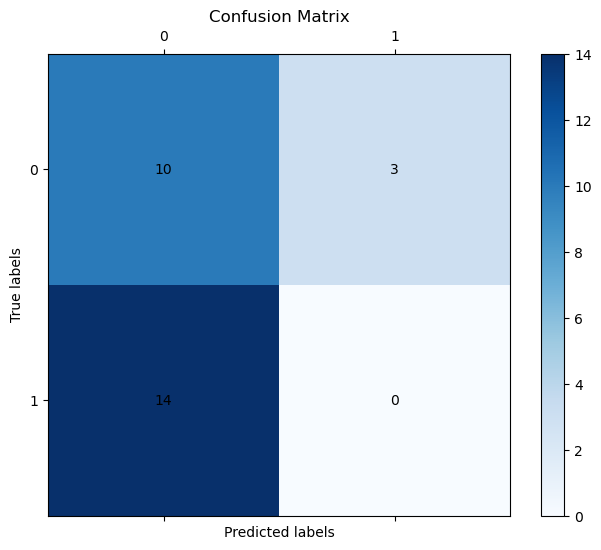

1/1 [==============================] - 0s 105ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.77      0.54        13
           1       0.00      0.00      0.00        14

    accuracy                           0.37        27
   macro avg       0.21      0.38      0.27        27
weighted avg       0.20      0.37      0.26        27




In [11]:
# Confusion matrix
true_labels = np.argmax(y_test, axis=1)
model_predictions = np.argmax(model.predict(X_test), axis=1)
conf_matrix = skm.confusion_matrix(true_labels, model_predictions)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, val, ha='center', va='center')

plt.show()

model_predictions = np.argmax(model.predict(X_test), axis=1)
true_labels = np.argmax(y_test, axis=1)
cls_report = skm.classification_report(true_labels, model_predictions)
print(f"Classification Report:\n{cls_report}\n")
